In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import det, inv
from scipy.special import gamma
from math import pi, ceil
from scipy.special import erfinv

from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from random import randint
import warnings
from math import sqrt, log
from numpy.linalg import lstsq
import networkx as nx


In [203]:
import ARXT
from ARXT import hit_rate
# import Data_gen
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
import matplotlib.pyplot as plt
import logging
import bayesian_changepoint_detection.bayesian_models as bayes_models
from bayesian_changepoint_detection.hazard_functions import constant_hazard
import bayesian_changepoint_detection.online_likelihoods as online_ll
import time 
from numpy.linalg import lstsq


def get_data(differencing = False):

    # tickers = ["^GSPC", "^IXIC", "^DJI","JPYUSD=X", "^VIX", "GBPUSD=X", "EURUSD=X] # , "GBPUSD=X", "EURUSD=X",
    # data = data_gen.collect_data(tickers)
    data = pd.read_csv("../Data/fin_data.csv")
    # data.to_csv("data/fin_data.csv")
    data.index = data["Date"]
    data = data.drop(["Date"], axis=1)
    data = data.pct_change()
    data = data.iloc[1:,:]

    data.columns = range(data.shape[1])
    if differencing:
        data = data.diff()
        data = data.iloc[1:,:]

    else:
        data = pd.DataFrame(np.log1p(data))
    data = data*100

    return(data)


def train_run_tree(data, p, max_depth, min_size, max_weight, splt):
    p, max_depth, min_size =  int(round(p)), int(round(max_depth)), int(round(min_size))
    d_val_cumsum, valid_prediction_cumsum, tree_list = ARXT.ARXT_time_series_pred(data=data, p=p, preprocessing_method='normalization', max_depth=max_depth, min_size=min_size, max_weight=max_weight, splt=splt)
    hit_rate_sample = hit_rate(d_val_cumsum, valid_prediction_cumsum)

    rmse_sample = (sqrt(mean_squared_error(d_val_cumsum, valid_prediction_cumsum)))

    return d_val_cumsum, valid_prediction_cumsum, tree_list, hit_rate_sample, rmse_sample
DATA = get_data(differencing=True)

def objective_function(p, max_depth, min_size, max_weight, start, fin, splt):
    # Set up and train the ART model using the hyperparameters
    p, max_depth, min_size, max_weight =  round(p), round(max_depth), round(min_size), round(max_weight)
    d_val_cumsum, valid_prediction_cumsum, _, hit_rate_sample, rmse_sample = train_run_tree(DATA[start:fin], p, max_depth, min_size, max_weight, splt=splt)

    performance = hit_rate_sample * 2 - rmse_sample * 0.5
    return performance
def optimizer(pbounds, start, fin, splt, init_points=10, n_iter=30):
    optimizer = BayesianOptimization(f= lambda p, max_depth, min_size, max_weight: objective_function(p, max_depth, min_size, max_weight, start, fin, splt), pbounds=pbounds, random_state=1)
    acq_function = UtilityFunction(kind="ei", kappa=5, kappa_decay=0.8)
    optimizer.maximize(init_points, n_iter, acquisition_function = acq_function)
    opt_params  = optimizer.max['params']
    return opt_params
def ARXT_tree(splt, tune):
    start_time = time.time()
    train_len = 1000
    # Define hyperparameter bounds
    pbounds = {
        "p": (5, 20),
        "max_depth":(10, 150),
        "min_size":(1, 50),
        "max_weight": (0.01, 0.15)
    }
    opt_params = optimizer(pbounds, 0 , train_len, splt)
    p, max_depth, min_size, max_weight = round(opt_params['p']), round(opt_params['max_depth']), round(opt_params['min_size']), opt_params['max_weight']
    next_pbounds = {"p": (p*0.7, p*1.3), "max_depth" : (max_depth*0.7, max_depth*1.3), "min_size" : (min_size*0.7, min_size*1.3), "max_weight" : (max(0.001, max_weight*0.7), max_weight*1.3)}

    ART = ARXT.AutoregressiveTree(p, splt=splt)    

    _, _, tree, _, _ = train_run_tree(data=DATA.iloc[200:train_len], p=p, max_depth=max_depth, min_size=min_size, max_weight=max_weight, splt=splt)
    c_det = bayes_models.OnlineChagepoint(np.array(DATA[0]), constant_hazard, 200)
    log_likelihood_class = c_det.warm_run(llc = online_ll.StudentT(alpha=0.1, beta=.01, kappa=1, mu=0),t = train_len)
    Nw = 200
    forecasts = []
    retraining_points = []
    for i in range(train_len, len(DATA[0])):
        forecasts.append(ARXT.forecast(DATA.iloc[i-200:i], tree, ART, p))

        if c_det.iteration(i, log_likelihood_class, Nw):
            print("retraining at ", DATA.index[i])
            retraining_points.append(DATA.index[i])
            if tune:
                opt_params = optimizer(next_pbounds, i-500, i, splt, init_points=5, n_iter = 10)
                p, max_depth, min_size, max_weight = round(opt_params['p']), round(opt_params['max_depth']), round(opt_params['min_size']), opt_params['max_weight']
                next_pbounds = {"p": (p*0.7, p*1.3), "max_depth" : (max_depth*0.7, max_depth*1.3), "min_size" : (min_size*0.7, min_size*1.3), "max_weight" : (max(0.001, max_weight*0.7), max_weight*1.3)}

            ART = ARXT.AutoregressiveTree(p, splt=splt)    
    
            _, _, tree, _, _ = train_run_tree(data=DATA[i-600:i], p=p, max_depth=max_depth, min_size=min_size, max_weight=max_weight, splt=splt)
    retrain = "retrain"
    if tune: retrain = "retune"
    pd.DataFrame(forecasts).to_csv("forecasts_{}_{}.csv".format(splt, retrain))
    pd.DataFrame(retraining_points).to_csv("retraining_points.csv".format(splt))

    plt.plot(DATA.iloc[train_len:,0], label="truth")
    plt.plot(forecasts, label="forecasts")
    plt.legend()
    plt.show()
    end_time = time.time()
    duration = end_time-start_time
    print("Time taken for ARXT {} {}: {}".format(splt, retrain, duration))
    return forecasts, retraining_points

# ARTX_exog_tuned, retraining_points = ARXT_tree("exog", True)


In [83]:
DATA

,0,1,2,3,4,5,6,7,8
Date,,,,,,,,,
2003-01-02,3.266078,-1.255667,3.137756,3.627856,-11.975043,2.768538,2.309543,-0.573273,0.000000
2003-01-03,-0.048415,0.450228,-0.067744,0.160897,-2.836216,0.306023,-4.419511,-0.576578,-1.227009
2003-01-06,2.222554,0.259378,1.978508,2.438519,0.927611,8.192128,3.148489,-1.676424,0.615387
2003-01-07,-0.656613,-0.717925,-0.376615,0.718573,0.879300,-1.357059,2.261907,-0.552793,-0.615387
2003-01-08,-1.418572,0.927602,-1.676102,-2.153551,1.579194,-2.486558,-3.182434,-0.555866,5.406722
...,...,...,...,...,...,...,...,...,...
2022-12-26,0.000000,-0.326611,0.000000,0.000000,0.000000,-0.270319,0.247764,-0.876312,0.000000
2022-12-27,-0.405784,0.019575,0.113262,-1.387287,3.669268,-0.026790,-0.470778,-0.475060,2.690745
2022-12-28,-1.209347,-0.542339,-1.106674,-1.360878,2.238046,-0.071475,0.029515,-0.477328,0.881063


In [204]:
def preprocessing(data, method):
    ts_train = []
    ts_valid = []
    ts_param = []
    flag_n = False
    flag_diff = False
    flag_dec = False
    if method == 'normalization':
        flag_n = True
    elif method == 'differencing':
        flag_diff = True
            
    for i in range(data.shape[1]):

        temp = list(data.iloc[6:][i].dropna())
        cut_off_1 = ceil(len(temp)*0.7)
        temp_train = temp[:cut_off_1]
        temp_val = temp[cut_off_1:]

        if flag_n is True:
            ts_param.append([np.mean(temp_train), np.std(temp_train), np.mean(temp_val), 
            np.std(temp_val)])
            
            temp_train = (temp_train - np.mean(temp_train)) / np.std(temp_train)
            ts_train.append(temp_train)
            

            temp_val = (temp_val - np.mean(temp_val)) / np.std(temp_val)
            ts_valid.append(temp_val)

        elif flag_diff is True:

            temp_train_diff = [temp_train[i] - temp_train[i - 1] for i in range(1, len(temp_train))]
            temp_train_diff = [temp_train[0]] + temp_train_diff
            ts_train.append(temp_train_diff)

            temp_val_diff = [temp_val[i] - temp_val[i - 1] for i in range(1, len(temp_val))]
            temp_val_diff = [temp_val[0]] + temp_val_diff
            ts_valid.append(temp_val_diff)
                
    return ts_train, ts_valid, ts_param

In [139]:
import numpy as np
from numpy.linalg import det, inv
from scipy.special import gamma
from math import pi
from scipy.special import erfinv

class AutoregressiveTree:
    
    def __init__(self, p, u0=0, alpha_u=1):
        
        erf_temp = np.zeros([7,1])
        for i in range(1,8):
            erf_temp[i-1] = erfinv((i/4) - 1)
        
        self._erf = erf_temp
        self._p = p
        self._alpha_W = p + 2
        self._u0 = u0
        self._alpha_u = alpha_u
    #  calculate the sample mean of the data (could be a vector), maybe split into sample mean of each variable
    def sample_mean(self, data):
        return sum(data) / len(data)
    
    # calculate the scatter matrix around the mean uN
    def scatter_matrix(self, data, uN_):
        temp = data - uN_
        SN = 0
        for row in temp:
            row = row[:, np.newaxis]
            SN += row * row.T
        # print(len(SN),len(SN[0]))
        return SN
    # updates the WN matric for the autoregressive model. Involves uses mean, variance matrix original wn and length of data, the covariance matrix of the strucutre
    def WN_func(self, uN_, SN, W0, N):
        temp = self._u0 - uN_
        temp = temp[:, np.newaxis]
        WN = W0 + SN + ((self._alpha_u * N) / (self._alpha_u + N)) * np.dot(temp, temp.T)
        return WN
    # Updates the matrix WN_d, calculates the within node covariance matrix 
    def WN_d_func(self, u0_, uN_d_, SN_d_, W0_, N_):
        temp = u0_ - uN_d_
        temp = temp[:, np.newaxis]
        WN_ = W0_ + SN_d_ + ((self._alpha_u * N_) / (self._alpha_u + N_)) * np.dot(temp, temp.T)
        return WN_
    # calculating the Maximum a posteriori arameters for the ar model
    def MAP_param(self, N, uN_, WN):
        ut = ((self._alpha_u * self._u0) + (N * uN_)) / (self._alpha_u + N)
        Wt_inv = (1 / (self._alpha_W + N - (self._p + 1))) * WN
        return ut, Wt_inv
    # calculate all of the AR parameters needed 
    def param(self, data):
        N = len(data)
        uN_ = self.sample_mean(data)
        SN = self.scatter_matrix(data, uN_)
        W0 = np.identity(SN.shape[0])
        WN = self.WN_func(uN_, SN, W0, N)
        ut, Wt_inv = self.MAP_param(N, uN_, WN)
        W = inv(Wt_inv)
        var = 1 / W[-1, -1]
        Wpp = inv(Wt_inv[:-1, :-1])
        b = np.zeros([self._p, 1])
        for j in range(len(b)):
            for i in range(self._p):
                b[j] += Wt_inv[-1, i] * Wpp[i, j]
        
        m = ut[-1]
        for i in range(self._p):
            m += b[i] * ut[i]
        
        return var, b, m[0]
    # scaling function using the gamma distribution
    def c_func(self, l, alpha):
        c = 1
        #   for loop goes from 1 to l
        for i in range(1, l + 1):
            c *= gamma((alpha + 1 - i) / 2)
        
        return c
    # probability density scaling function used
    def pds_func(self, N, W0, WN):
        pds = (pi**(-((self._p + 1) * N) / 2)) + \
        ((self._alpha_u / (self._alpha_u + N))**((self._p + 1) / 2)) + \
        (self.c_func(self._p + 1, self._alpha_W + N) / self.c_func(self._p + 1, self._alpha_W)) * (det(W0)**(self._alpha_W / 2))*(det(WN)**(-(self._alpha_W + N) / 2))
        return pds
    # similiar to above just now with different params
    def pd_s_func(self, u0_, N_, W0_, WN_):
        pds = (pi**(-((self._p + 1) * N_) / 2)) + \
        ((self._alpha_u / (self._alpha_u + N_))**((self._p + 1) / 2)) + \
        (self.c_func(self._p + 1, self._alpha_W - 1 + N_) / self.c_func(self._p + 1, self._alpha_W - 1)) * (det(W0_)**((self._alpha_W - 1) / 2))*(det(WN_)**(-(self._alpha_W - 1 + N_) / 2))
        return pds
    # Calculates the score aof a leaf node using the above prob density's
    def LeafScore(self, data):
        N = len(data)
        # try:
        uN_ = self.sample_mean(data)
        # except:
        #     uN_ = 0.0001
        SN = self.scatter_matrix(data, uN_)
        W0 = np.identity(SN.shape[0])
        WN = self.WN_func(uN_, SN, W0, N)
        ut, Wt_inv = self.MAP_param(N, uN_, WN)
        pds = self.pds_func(N, W0, WN)
        data_ = []
        for x in data:
            data_.append(x[:-1])
        
        N_ = len(data_)
        uN_d_ = self.sample_mean(data_)
        SN_d_ = self.scatter_matrix(data_, uN_d_)
        u0_ = ut[:-1]
        W0_ = inv(inv(W0)[:-1, :-1])
        WN_d_ = self.WN_d_func(u0_, uN_d_, SN_d_, W0_, N_)
        pds_ = self.pd_s_func(u0_, N_, W0_, WN_d_)
        return pds / pds_
    # This will spplit a dataset into two froups based on the specific features. Then splits the data points into the left or right set
    def test_split(self, index, value, dataset):
        left, right = list(), list()
        for row in dataset:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return left, right
    # itrates through the features and the values to det the best for splitting the dataset, calkculates the score for each split and choses the one with best improvement
    def get_split(self, dataset):
        b_index, b_value, b_groups = 999, 999, None
        b_score = self.LeafScore(dataset)
        avg = np.mean(dataset, axis=0)[:-1]
        sigma = np.std(dataset, axis=0)[:-1]
        for index in range(len(avg)):
            for i in range(len(self._erf)):
                value = avg[index] + sigma[index] * self._erf[i]
                groups = self.test_split(index, value, dataset)
                new_score = 1
                for group in groups:
                    if len(group) != 0:
                        new_score *= self.LeafScore(group)
            
                        if new_score > b_score:
                            b_index, b_value, b_score, b_groups = index, value, new_score, groups
        
        return {'index':b_index, 'value':b_value, 'groups':b_groups}
    # turns a group of points, belonging to one datagroup into a terminal node, calculates the parameters for that specific group
    def to_terminal(self, group):
        outcomes = self.param(group)
        return outcomes
    # this recursivelky builds the tree up. If the node should be a terminal node make terminal, else use get split to find next best split
    def split(self, node, max_depth, min_size, depth):
        left, right = node['groups']
        del(node['groups'])
        if not left or not right:
            node['left'] = node['right'] = self.to_terminal(left + right)
            return
        
        if depth >= max_depth:
            node['left'], node['right'] = self.to_terminal(left), self.to_terminal(right)
            return
        
        if len(left) <= min_size:
            node['left'] = self.to_terminal(left)
        else:
            node['left'] = self.get_split(left)
            if node['left']['groups'] is None:
                node['left'] = self.to_terminal(left)
            else:
                self.split(node['left'], max_depth, min_size, depth+1)
        
        if len(right) <= min_size:
            node['right'] = self.to_terminal(right)
        else:
            node['right'] = self.get_split(right)
            if node['right']['groups'] is None:
                node['right'] = self.to_terminal(right)
            else:
                self.split(node['right'], max_depth, min_size, depth+1)
    # initiates the buiilding process. Finds initial split and if there are no effective splits then makes source node a terminal node
    def build_tree(self, train, max_depth, min_size):
        root = self.get_split(train)
        if root['groups'] is None:
            root['root'] = self.to_terminal(train)
            root['index'] = None
            root['value'] = None
            del(root['groups'])
        else:
            self.split(root, max_depth, min_size, 1)
        
        return root
    # prints the tree structure 
    def print_tree(self, node, depth=0):
        if isinstance(node, dict):
            if node['value'] is None:
                print(node)
                return                                                                                                                               
            print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
            self.print_tree(node['left'], depth+1)
            self.print_tree(node['right'], depth+1)
    
        else:
            print('%s[%s]' % ((depth*' ', node)))
    # follows the tree strarting from root node until a terminal node is found
    def predict(self, node, row):
        if 'root' in node:
            return node['root']
        if row[node['index']] < node['value']:
            if isinstance(node['left'], dict):
                return self.predict(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self.predict(node['right'], row)
            else:
                return node['right']

In [205]:
def ART_time_series_pred(data, p, preprocessing_method, max_depth, min_size):
    ts_train, ts_valid, ts_param = preprocessing(data, method=preprocessing_method)
    data = np.array(data)
    idx = 0
    d_val = np.array(ts_valid)[0]
    max_len = len(d_val) - p
    train=[]
    valid=[]
    for ind in range(len(ts_train)):
        s = ts_train
        for s in ts_train:
            temp = []
            for i in range(len(s) - (p + 1)):
                temp.append(s[i:i + p + 1])

            train.append(temp)
    d = train[0]

    # comb = np.concatenate(train, axis=1)
    # comb_val = np.concatenate(valid, axis=1)

    ART = AutoregressiveTree(p)
    tree = ART.build_tree(d, max_depth, min_size)

    valid_prediction = []
    valid_window = d[p-1][1:]

    for i in range(len(d_val)):
            parameters = ART.predict(tree, valid_window)
            prediction_temp = np.dot(valid_window[:,np.newaxis].T,parameters[1]) + parameters[2]
            valid_prediction.append(prediction_temp[0][0])
            valid_window = np.append(valid_window, d_val[i])
            valid_window = valid_window[1:]
    valid_prediction = pd.Series(valid_prediction, copy=True)
    if preprocessing_method == 'differencing':
        valid_prediction = pd.Series(valid_prediction[:max_len], copy=True)
        train_s = pd.Series(ts_train[idx], copy=True).cumsum()
        last_value_train= pd.Series.tolist(train_s)[-1]
        valid_prediction_temp = [0]*(len(valid_prediction)+1)
        valid_prediction_temp[1:] = valid_prediction
        valid_prediction_temp[0] = last_value_train
        valid_prediction_temp = pd.Series(valid_prediction_temp, copy=True)
        valid_prediction_cumsum = valid_prediction_temp.cumsum()             
        
    elif preprocessing_method == 'normalization':
        valid_prediction = pd.Series(valid_prediction[:max_len], copy=True)
        d_val_mean = ts_param[idx][2]
        d_val_std = ts_param[idx][3]
        valid_prediction_denorm = (valid_prediction * d_val_std) + d_val_mean
        valid_prediction_cumsum = (valid_prediction_denorm)
    else: 
        valid_prediction_cumsum = [0]*(len(valid_prediction)+1)
        valid_prediction_cumsum[1:] = valid_prediction

    if preprocessing_method == 'differencing':
        d_val_cumsum = np.array(ts_valid[idx]).cumsum()[1:]
    elif preprocessing_method == 'normalization':
        d_val_mean = ts_param[idx][2]
        d_val_std = ts_param[idx][3]
        d_val_cumsum = (d_val[:max_len] * d_val_std) + d_val_mean
    else:
        d_val_cumsum = d_val[:max_len+3]

        
    return d_val_cumsum, valid_prediction_cumsum, tree

def forecast_ART(data, tree, ART, p):
    data = data.iloc[0]
    ts_param = [np.mean(data), np.std(data)]
    temp_data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
    # temp_data = temp_data[0]
    valid_window = np.array(data[-p-1:].iloc[::-1])
    parameters = ART.predict(tree, valid_window[1:])
    prediction = np.dot(valid_window[1:][:,np.newaxis].T,parameters[1]) + parameters[2]  
    prediction_temp = prediction[0]*ts_param[1] + ts_param[0]

    return prediction_temp[0]

In [206]:
def train_run_ART(data, p, max_depth, min_size):
    p, max_depth, min_size =  int(round(p)), int(round(max_depth)), int(round(min_size))
    d_val_cumsum, valid_prediction_cumsum, tree_list = ART_time_series_pred(data=data, p=p, preprocessing_method='normalization', max_depth=max_depth, min_size=min_size)
    # print(d_val_cumsum, valid_prediction_cumsum)
    hit_rate_sample = hit_rate(d_val_cumsum, valid_prediction_cumsum)

    rmse_sample = (sqrt(mean_squared_error(d_val_cumsum, valid_prediction_cumsum)))

    return d_val_cumsum, valid_prediction_cumsum, tree_list, hit_rate_sample, rmse_sample

In [214]:
data = DATA
p = 5
train_len = 1000
max_depth = 150
min_size = 10
ART = AutoregressiveTree(p)    

# d_val_cumsum, valid_prediction_cumsum, tree, _, _ = train_run_ART(data=data.iloc[200:train_len], p=p, max_depth=max_depth, min_size=min_size)


In [208]:
CPS = pd.read_csv('../Data/changepoints.csv').to_numpy()

def objective_function(p, max_depth, min_size, max_weight, start, fin, splt, data, ART_bool):
    # Set up and train the ART model using the hyperparameters
    if ART_bool:
        p, max_depth, min_size =  round(p), round(max_depth), round(min_size)
        d_val_cumsum, valid_prediction_cumsum, _, hit_rate_sample, rmse_sample = train_run_ART(data[start:fin], p, max_depth, min_size)

    else:
        p, max_depth, min_size, max_weight =  round(p), round(max_depth), round(min_size), max_weight
        d_val_cumsum, valid_prediction_cumsum, _, hit_rate_sample, rmse_sample = train_run_tree(data[start:fin], p, max_depth, min_size, max_weight, splt=splt)

    performance = 2 * hit_rate_sample - rmse_sample * 0.5
    return performance

def optimizer(pbounds, start, fin, splt, data, ART_bool, init_points=10, n_iter=30):
    if ART_bool:
        optimizer = BayesianOptimization(f= lambda p, max_depth, min_size: objective_function(p, max_depth, min_size, 0, start, fin, splt, data, ART_bool), pbounds=pbounds, random_state=1)
    else:
        optimizer = BayesianOptimization(f= lambda p, max_depth, min_size, max_weight: objective_function(p, max_depth, min_size, max_weight, start, fin, splt, data, ART_bool), pbounds=pbounds, random_state=1)
    acq_function = UtilityFunction(kind="ei", kappa=5, kappa_decay=0.8)
    # logger = JSONLogger(path=f"./logs_{splt}_{retune_it}.log")
    # optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
    optimizer.maximize(init_points, n_iter, acquisition_function = acq_function)
    opt_params  = optimizer.max['params']
    return opt_params

In [215]:
pbounds = {
        "p": (1, 20),
        "max_depth":(10, 150),
        "min_size":(1, 50)
        }

opt_params = optimizer(pbounds, 0 , train_len, "no", data, True)
p, max_depth, min_size = round(opt_params['p']), round(opt_params['max_depth']), round(opt_params['min_size'])
next_pbounds = {"p": (p*0.7, p*1.3), "max_depth" : (max_depth*0.7, max_depth*1.3), "min_size" : (min_size*0.7, min_size*1.3)}


|   iter    |  target   | max_depth | min_size  |     p     |
-------------------------------------------------------------
| 1         | 0.9785    | 68.38     | 36.3      | 1.002     |
| 2         | 1.185     | 52.33     | 8.191     | 2.754     |
| 3         | 1.237     | 36.08     | 17.93     | 8.539     |
| 4         | 1.237     | 85.43     | 21.54     | 14.02     |
| 5         | 1.165     | 38.62     | 44.03     | 1.52      |
| 6         | 1.248     | 103.9     | 21.45     | 11.62     |
| 7         | 1.22      | 29.65     | 10.71     | 16.21     |
| 8         | 1.237     | 145.6     | 16.36     | 14.15     |
| 9         | 1.185     | 132.7     | 44.84     | 2.616     |
| 10        | 1.199     | 15.47     | 9.322     | 17.68     |
| 11        | 1.24      | 103.3     | 21.8      | 11.04     |
| 12        | 1.199     | 107.1     | 17.71     | 17.91     |
| 13        | 1.23      | 109.4     | 21.93     | 10.39     |
| 14        | 1.22      | 104.6     | 25.79     | 15.88     |
| 15    

In [217]:
ART = ARXT.AutoregressiveTree(p)    

_, _, tree, _, _ = train_run_ART(data=data.iloc[200:train_len], p=p, max_depth=max_depth, min_size=min_size)
tune = True
forecasts = []
for i in range(train_len, len(data[0])):
    forecasts.append(forecast_ART(data.iloc[i-200:i], tree, ART, p))
    if tune:
        if data.index[i] in CPS:
            print("retuning at ", data.index[i])
            opt_params = optimizer(next_pbounds, i-500, i, "no", data, True, init_points=5, n_iter = 10)
            p, max_depth, min_size, = round(opt_params['p']), round(opt_params['max_depth']), round(opt_params['min_size'])
            next_pbounds = {"p": (p*0.7, p*1.3), "max_depth" : (max_depth*0.7, max_depth*1.3), "min_size" : (min_size*0.7, min_size*1.3)}
    
            _, _, tree, _, _ = train_run_ART(data=data[i-600:i], p=p, max_depth=max_depth, min_size=min_size)
    

ValueError: shapes (1,8) and (13,1) not aligned: 8 (dim 1) != 13 (dim 0)

In [ ]:
ART = ARXT.AutoregressiveTree(p)    

_, _, tree, _, _ = train_run_ART(data=data.iloc[200:train_len], p=p, max_depth=max_depth, min_size=min_size)
tune = False
forecasts_train = []
for i in range(train_len, len(data[0])):
    forecasts_train.append(forecast_ART(data.iloc[i-1000:i], tree, ART, p))
    if tune:
        if data.index[i] in CPS:
            print("retuning at ", data.index[i])
            opt_params = optimizer(next_pbounds, i-500, i, "no", data, True, init_points=5, n_iter = 10)
            p, max_depth, min_size, = round(opt_params['p']), round(opt_params['max_depth']), round(opt_params['min_size'])
            next_pbounds = {"p": (p*0.7, p*1.3), "max_depth" : (max_depth*0.7, max_depth*1.3), "min_size" : (min_size*0.7, min_size*1.3)}
    
            _, _, tree, _, _ = train_run_ART(data=data[i-1000:i], p=p, max_depth=max_depth, min_size=min_size)
    

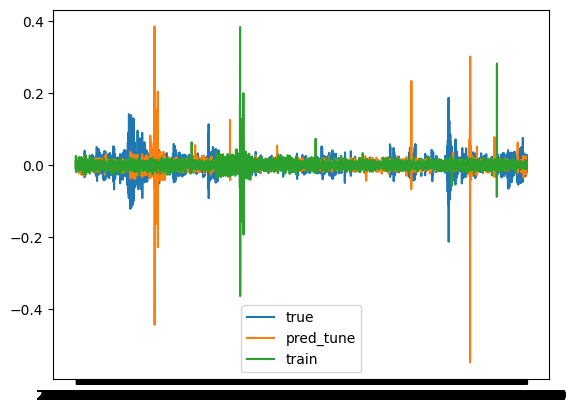

In [ ]:
plt.plot(data.iloc[train_len:,0], label="true")
plt.plot(forecasts, label="pred_tune")
plt.plot(forecasts_train, label = "train")
plt.legend()
plt.show()

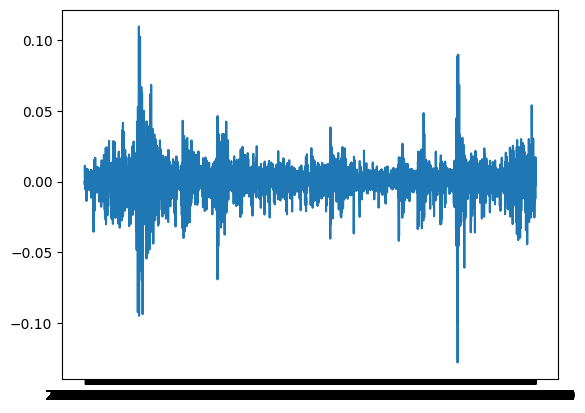

In [176]:
plt.plot(data.iloc[train_len:,0], label="true")
plt.show()

In [93]:
plt.plot(forecasts, label="pred_tune")


In [213]:
forecast_ART_trained = forecasts
pd.DataFrame([forecasts, forecasts_train]).to_csv(f"..\\Data\\results_ART_diff.csv")


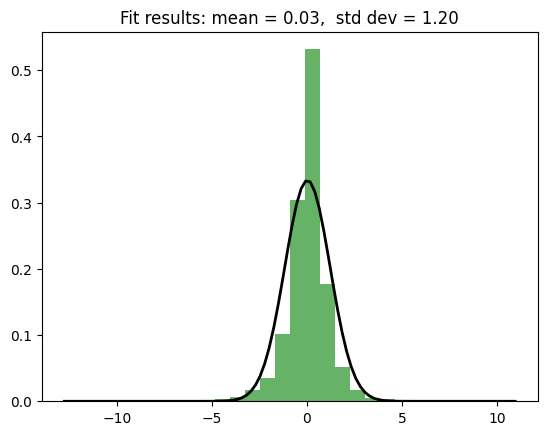

In [118]:
from scipy.stats import norm
data2 = data[0]*100
mean = np.mean(data2)
std_dev = np.std(data2)

xmin, xmax = plt.xlim()
x = np.linspace(min(data2), max(data2), 100)
p = norm.pdf(x, mean, std_dev)

# Create the histogram
plt.hist(data2, bins=30, density=True, alpha=0.6, color='g')

# Add the normal distribution curve
plt.plot(x, p, 'k', linewidth=2)

title = "Fit results: mean = %.2f,  std dev = %.2f" % (mean, std_dev)
plt.title(title)
plt.show()

In [107]:
x

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747